In [1]:
# Import libraries
import pandas as pd
from scipy import io
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Path to the folder where GEO files 
base = "."  

# Read in the matrix
print("Reading matrix...")
mat = io.mmread(f"{base}/GSE211644_fresh_matrix.mtx.gz").T.tocsr()

print("Reading gene and barcode lists...")
genes = pd.read_csv(f"{base}/GSE211644_fresh_genes.tsv.gz", sep="\t", header=None)
barcodes = pd.read_csv(f"{base}/GSE211644_fresh_barcodes.tsv.gz", sep="\t", header=None)
# create pandas DataFrame
df=pd.DataFrame.sparse.from_spmatrix(mat)
df.columns = genes.iloc[:, 0].astype(str).values
df.index = barcodes.iloc[:, 0].astype(str).values

print("Reading metadata...")
meta = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv.gz")

meta["sample"] = meta["barcode"].str.split("_").str[0]

meta.index = meta["barcode"]
df = df.reindex(meta.index)
df["barcode"] = df.index

# Inspect what samples exist 
print("Unique samples found in metadata:")
print(meta["sample"].unique())

# Subset for MDA1 and MDA2
df_MDA1 = df[df.index.isin(meta[meta["sample"] == "MDA1"]["barcode"])]
df_MDA2= df[df.index.isin(meta[meta["sample"] == "MDA2"]["barcode"])]

Reading matrix...
Reading gene and barcode lists...
Reading metadata...
Unique samples found in metadata:
['MDA1' 'MDA2']


In [3]:
df["cluster"]= meta["cluster"][df.index]
df["patient"]= df["barcode"].str.extract(r'(MDA\d_\w\d\d)')
df["cohort"]= df["barcode"].str.extract(r'(MDA\d)')
df["tissue type"]= df["barcode"].str.extract(r'_(\w)')
df["tissue type"]=df["tissue type"].replace({"U":"uninvolved", "T":"tumor"})
patient_cluster_counts = df.groupby(['patient', 'cluster']).size().unstack(fill_value=0)
cohort = df.drop_duplicates("patient").set_index("patient")["cohort"] 
type= df.drop_duplicates("patient").set_index("patient")["tissue type"]
categories = ["CD4 - FOXP3","CD4 - CXCR4","CD4 - CCR7","CD4 - CXCL13", "CD4 - MX1","CD8 - GZMK","CD8 - CXCR6/IL7R","CD8 - ZNF683","CD8 - GZMB/PRF1","CD8 - CXCL13","CD8 - CCR7/IL7R","CD8 - MX1", "Cycling"][::-1]

In [4]:


df_counts = patient_cluster_counts[categories]
df_proportion = df_counts.apply(lambda x: x / x.sum(), axis=1)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
dist = pdist(df_proportion.values, metric='euclidean')
link = linkage(dist, method='average')
leaves = leaves_list(link)
df_proportion = df_proportion.iloc[leaves, :]


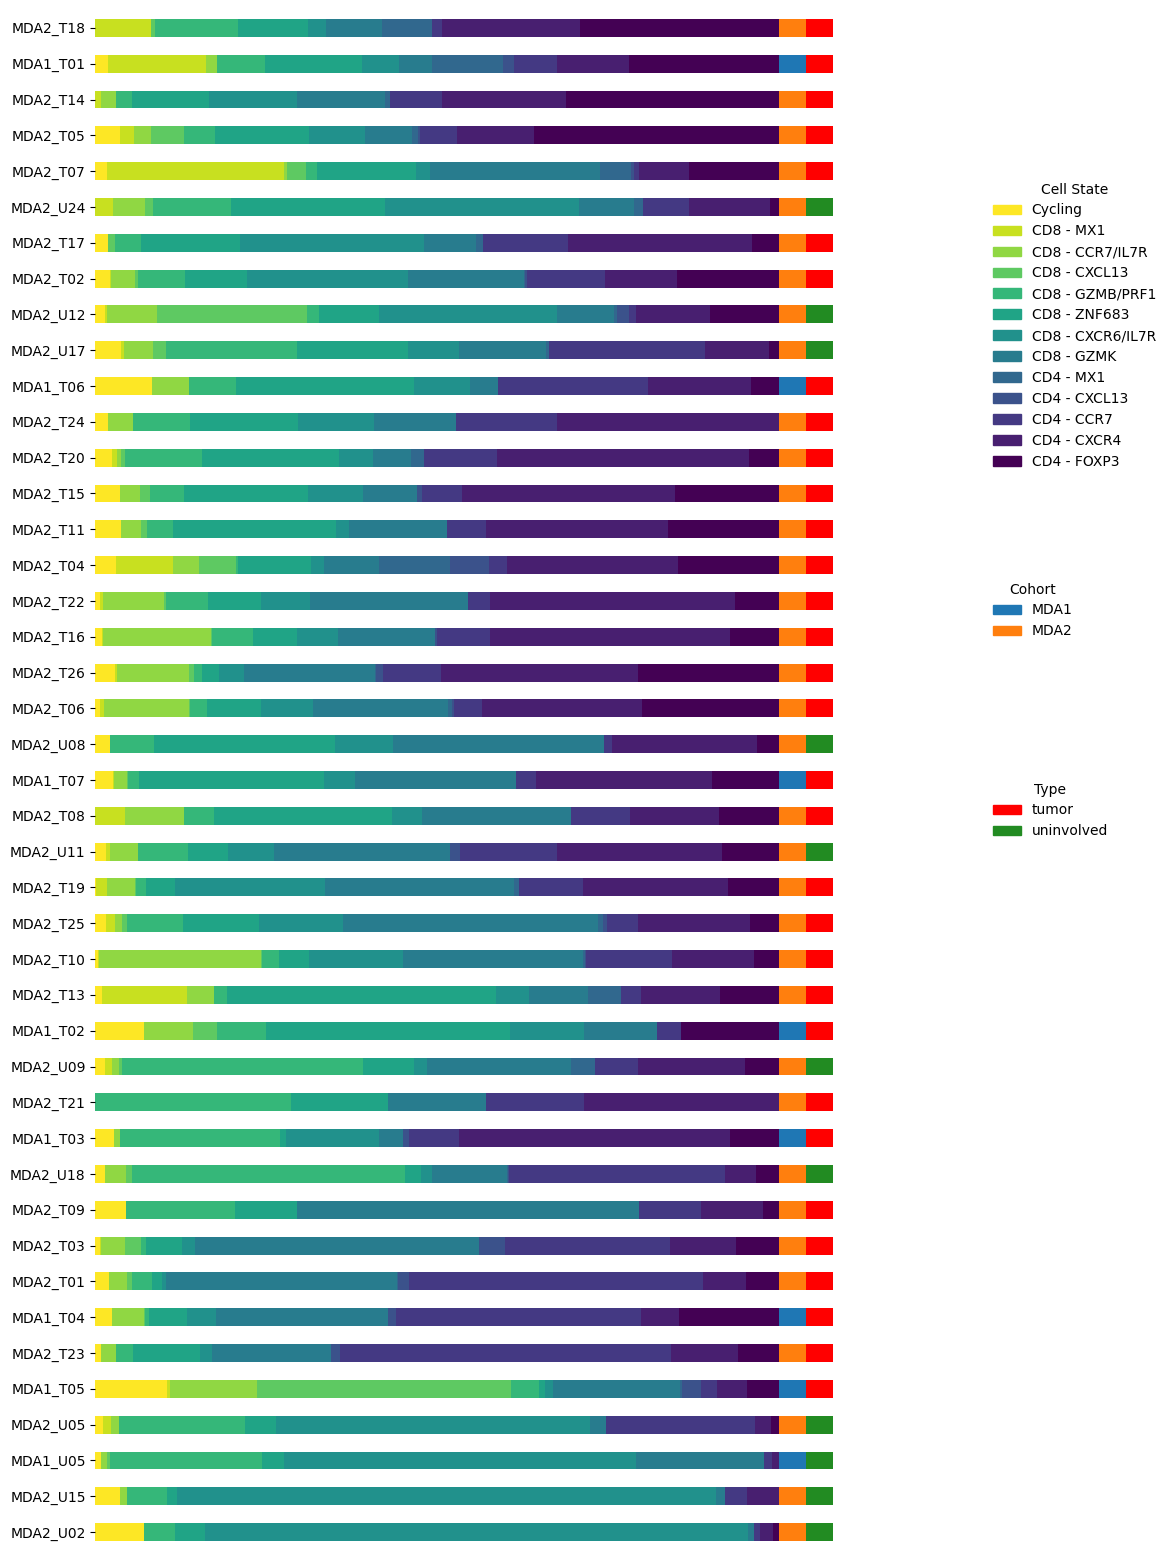

In [5]:


categories = df_proportion.columns
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(categories)))

unique_cohorts = cohort.unique()
cohort_color_map = dict(zip(unique_cohorts, plt.cm.tab10.colors[:len(unique_cohorts)]))
type_color_map = {'tumor': 'red', 'uninvolved': 'forestgreen'}  # example

fig, ax = plt.subplots(figsize=(10, 20))

df_proportion.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=colors[::-1],
    legend=False,
)


ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none')
for spine in ['top', 'right', 'left', 'bottom']:
    spine_obj = ax.spines[spine]
    spine_obj.set_visible(False)

ax.set_ylabel('')
ax.set_xlabel('')

y_positions = np.arange(len(df_proportion))

for i, patient in enumerate(df_proportion.index):
    ax.barh(
        y=i,
        width=0.04,
        left=1,
        height=0.5,
        color=cohort_color_map[cohort[patient]],
    )
    ax.barh(
        y=i,
        width=0.04,
        left= 1.04,
        height=.5,
        color=type_color_map[type[patient]],
    )

fig.legend().set_visible(False)

cluster_handles = [
    plt.Rectangle((0, 0), 1, 1, color=color)
    for color in colors[::-1]
]
fig.legend(
    cluster_handles,
    categories,
    title="Cell State",
    loc="upper left",
    bbox_to_anchor=(1.01, .8),  
    frameon=False,
)

cohort_handles = [
    plt.Rectangle((0, 0), 1, 1, color=cohort_color_map[c])
    for c in unique_cohorts
]
fig.legend(
    cohort_handles,
    unique_cohorts,
    title="Cohort",
    loc="upper left",
    bbox_to_anchor=(1.01, 0.6), 
    frameon=False,
)

type_handles = [
    plt.Rectangle((0, 0), 1, 1, color=type_color_map[t])
    for t in type_color_map
]
fig.legend(
    type_handles,
    list(type_color_map.keys()),
    title="Type",
    loc="upper left",
    bbox_to_anchor=(1.01, 0.5),  
    frameon=False,
)


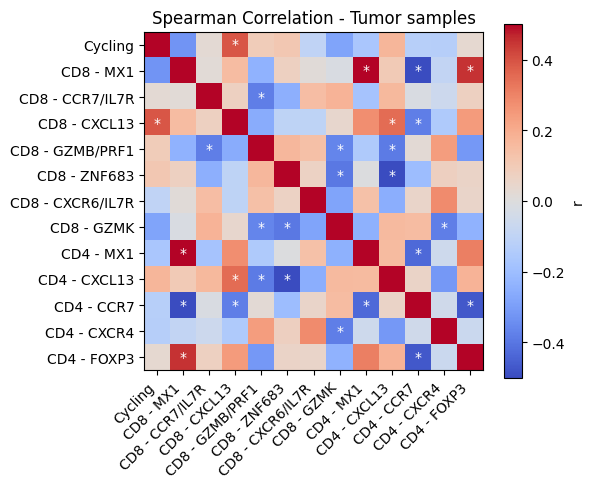

In [ ]:
# %%
# Spearman correlation heatmap for tumor samples only

from scipy.stats import spearmanr

# Keep only tumor samples
tumor_patients = type[type == "tumor"].index
df_tumor = df_proportion.loc[df_proportion.index.intersection(tumor_patients)]

# Make sure we have the same order of clusters as in the plot
clusters = df_tumor.columns  # e.g. CD8 - MX1, CD4 - MX1, ...

# Compute Spearman correlation (returns corr and p-value matrices)
corr, pval = spearmanr(df_tumor.values, axis=0)

corr_mat = pd.DataFrame(corr, index=clusters, columns=clusters)
pval_mat = pd.DataFrame(pval, index=clusters, columns=clusters)

# %%
# Plot heatmap

fig, ax = plt.subplots(figsize=(6, 5))

# Use a diverging colormap and symmetric limits (adjust as you like)
im = ax.imshow(
    corr_mat.values,
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
)

# Tick labels
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters, rotation=45, ha="right")
ax.set_yticklabels(clusters)

# Title
ax.set_title("Spearman Correlation - Tumor samples")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("r")

# Add asterisks for significant correlations (e.g. p < 0.05)
for i in range(len(clusters)):
    for j in range(len(clusters)):
        if pval_mat.iloc[i, j] < 0.05 and i != j:
            ax.text(
                j,
                i,
                "*",
                ha="center",
                va="center",
                fontsize=10,
                color="white" if abs(corr_mat.iloc[i, j]) > 0.25 else "black",
            )

plt.tight_layout()
plt.show()


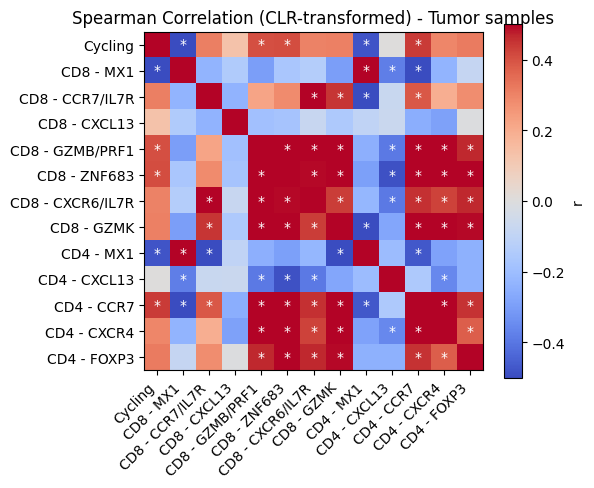

In [7]:
# %%
# Spearman correlation heatmap for tumor samples only (CLR-corrected)

from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Subset to tumor samples
# -------------------------------

tumor_patients = type[type == "tumor"].index
df_tumor = df_counts.loc[df_counts.index.intersection(tumor_patients)]  # USE COUNTS, NOT PROPORTIONS

clusters = df_tumor.columns

# -------------------------------
# 2. Handle zeros (pseudo-count)
# -------------------------------

df_tumor_nozero = df_tumor.replace(0, 1e-6)

# -------------------------------
# 3. CLR transformation
# -------------------------------
# CLR(x_i) = ln(x_i) - mean( ln(x_j) )
# done row-wise (per patient)

log_vals = np.log(df_tumor_nozero.values)
gm_mean = log_vals.mean(axis=1, keepdims=True)   # geometric mean in log space
clr_vals = log_vals - gm_mean

df_clr = pd.DataFrame(clr_vals, index=df_tumor.index, columns=clusters)

# -------------------------------
# 4. Spearman correlation on CLR-transformed data
# -------------------------------

corr, pval = spearmanr(df_clr.values, axis=0)

corr_mat = pd.DataFrame(corr, index=clusters, columns=clusters)
pval_mat = pd.DataFrame(pval, index=clusters, columns=clusters)

# -------------------------------
# 5. Plot heatmap
# -------------------------------

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(
    corr_mat.values,
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
)

ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters, rotation=45, ha="right")
ax.set_yticklabels(clusters)

ax.set_title("Spearman Correlation (CLR-transformed) - Tumor samples")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("r")

# significance markers
for i in range(len(clusters)):
    for j in range(len(clusters)):
        if pval_mat.iloc[i, j] < 0.05 and i != j:
            ax.text(
                j, i, "*",
                ha="center",
                va="center",
                fontsize=10,
                color="white" if abs(corr_mat.iloc[i, j]) > 0.25 else "black",
            )

plt.tight_layout()
plt.show()
